# Exploring Regression

This notebook explores linear regression by fitting polynomials of varying degrees to samples of a simple function, y = sin(x).

It shows **learning curves** for increasing number of training points,
and **complexity curves** for increasing model complexity,
and diagnoses problems of **high bias / underfitting** and **high variance / overfitting**. 

## Import Libraries

In [1]:
# allow inline plots
%matplotlib inline

import math
import random

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## Set parameters

In [2]:
# random seed
seed = 6
random.seed(seed)
np.random.seed(seed)

# default plot size, in inches (for my small laptop screen...)
figsize = (math.pi, 1.5)

## Define Population

In [3]:
# say the function we're trying to approximate is sin from 0 to pi
# so our dataset will come from this, randomly

# range
fxmin = 0.0
fxmax = math.pi

def f(xs):
    """
    Function defining a population.
    Pass in a list or array of x values, returns array of y values.
    """
    return np.sin(xs)

## Sample Data from Population

In [4]:
# Sample the function at random points

def getSample(f, noise=0.0, npoints=100, xmin=fxmin, xmax=fxmax):
    "Return a random sample of the population defined by f, with optional noise"

    # it seems that you need to do this in each block you use np.random (?)
    np.random.seed(seed)

    # get random x points
    xs = xmin + (xmax - xmin) * np.random.random_sample(npoints)
    
    # get function at those points, plus some normally-distributed noise
    ys = f(xs) + noise * np.random.standard_normal(len(xs))

    # sklearn uses X for features and y for outcomes.
    # values in X should be arrays of the form [feature1, feature2, ...],
    # but since we just have one feature, x, we just say [x].
    X = [[x] for x in xs]
    y = ys

    return X,y

noise = 0.5 # stddev
npoints = 50
X,y = getSample(f, noise, npoints)

print X[:5]
print y[:5]

[[2.805002892434413], [1.0429453174743482], [2.5799673799124725], [0.13099381305792829], [0.33821343479670457]]
[-0.05980593  1.34169626  0.46919433 -0.55368691  0.94104259]


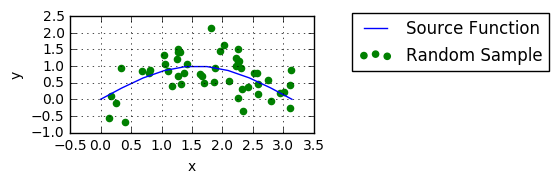

In [5]:
# show random sample and the source function

def plotSample(X,y,f=None):
    "plot the function f and random sample X,y"
    plt.figure(figsize=figsize)
    plt.scatter(X,y, color="g", label="Random Sample")
    if not f is None:
        xs = np.linspace(fxmin,fxmax,10)
        plt.plot(xs,f(xs), color="b", label="Source Function")
    plt.ylabel("y")
    plt.xlabel("x")
    plt.legend(bbox_to_anchor=(2, 1.1))
    plt.grid()
    plt.show()
    
plotSample(X,y,f)

## Linear Regression Model

In [6]:
# do simple linear regression on the random sample

# import the model
from sklearn import linear_model

# instantiate the model
reg = linear_model.LinearRegression()

# learn model parameters from the data
reg.fit(X,y)

# predict outcomes on all the data
ypredict = reg.predict(X)

In [7]:
# print some info
mse = np.mean((ypredict - y) ** 2)
variance = reg.score(X,y)

print 'coefficients', reg.coef_
print 'intercept', reg.intercept_
print 'mean squared error', mse
print 'variance', variance

coefficients [-0.00820935]
intercept 0.718662980768
mean squared error 0.339275412807
variance 0.000135116657331


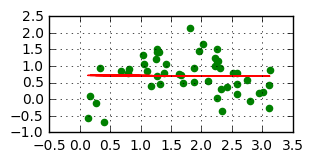

In [8]:
# plot the sample and regression line
plt.figure(figsize=figsize)
plt.scatter(X,y,color='g')
plt.plot(X, ypredict, color='r')
plt.grid()

## Linear Polynomial Regression Model

In [9]:
# fit a polynomial of arbitrary degree to the random sample

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degree = 2

# need a Pipeline object to handle polynomial fitting
# see http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html
poly = make_pipeline(PolynomialFeatures(degree), Ridge())
poly.fit(X, y)
ypredict = poly.predict(X)

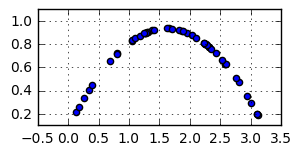

In [10]:
# show the polynomial that was fit to the random sample X, y
plt.figure(figsize=figsize)
plt.scatter(X,ypredict)
plt.grid()

## Learning Curves

In [11]:
# define a plotting fn

def plotLearningCurves(trainSizes, trainScores, testScores):
    "plot learning curves for training and testing scores as fn of number of training points"
    
    # learning_curve runs each case 3 times (the default for the cv parameter), 
    # so need to take average of them for plotting
    trainScoresMean = np.mean(trainScores,axis=1)
    testScoresMean = np.mean(testScores,axis=1)
    trainScoresStd = np.std(trainScores,axis=1)
    testScoresStd = np.std(testScores,axis=1)

    # make the plot
    plt.figure(figsize=figsize)
    plt.plot(trainSizes, trainScoresMean, 'o-', color="r", label="Training score")
    plt.plot(trainSizes, testScoresMean, 'o-', color="g", label="Cross-validation (test) score")    
    plt.fill_between(trainSizes, trainScoresMean - trainScoresStd,
                     trainScoresMean + trainScoresStd, alpha=0.1, color="r")
    plt.fill_between(trainSizes, testScoresMean - testScoresStd,
                     testScoresMean + testScoresStd, alpha=0.1, color="g")
    plt.ylim(-0.1, 1.2)
    plt.ylabel("Score")
    plt.xlabel("Training Points")
    plt.legend(bbox_to_anchor=(2.5, 1.1))
    plt.grid()
    plt.show()

In [12]:
# make a learning curve

from sklearn.learning_curve import learning_curve

# make polynomial model of degree 2
degree = 2
poly = make_pipeline(PolynomialFeatures(degree), Ridge())

# learning_curve will run cross-validation tests for an increasing number of training points.
#scoring = 'r2' # the default
scoring = 'mean_squared_error'
trainSizes, trainScores, testScores = learning_curve(poly, X, y, scoring=scoring)

# must change sign of scores if using mean_squared_error
if scoring=='mean_squared_error':
    trainScores = -trainScores
    testScores = -testScores

scoring mean_squared_error
degree 2
noise 0.5
npoints 50


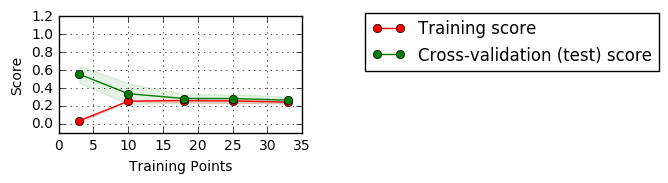

In [13]:
# show learning curve
print 'scoring',scoring
print 'degree',degree
print 'noise',noise
print 'npoints',npoints
plotLearningCurves(trainSizes, trainScores, testScores)

## Compare Learning Curves

In [14]:
# define a higher level plotting function so can compare learning curves for different parameters

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.learning_curve import learning_curve

def calculateAndPlotLearningCurves(f, noise=0.0, npoints=100, degree=1, scoring='mean_squared_error'):
    """
    get a sample of `npoints` from function `f` with noise `noise`,
    fit a polynomial model of degree `degree` to the data,
    obtain scores using given scoring system for increasing number of training data,
    and plot the learning curves. 
    """
    
    X,y = getSample(f, noise, npoints)
    
    # define a polynomial model of degree `degree`
    poly = make_pipeline(PolynomialFeatures(degree), Ridge())

    # get learning curves
    trainSizes, trainScores, testScores = learning_curve(poly, X, y, scoring=scoring)

    # must change sign of scores if using mean_squared_error
    if scoring=='mean_squared_error':
        trainScores = -trainScores
        testScores = -testScores

    print 'scoring',scoring
    print 'degree',degree
    print 'noise',noise
    print 'npoints',npoints

    plotLearningCurves(trainSizes, trainScores, testScores)

### polynomial degree 2

scoring mean_squared_error
degree 2
noise 0.1
npoints 50


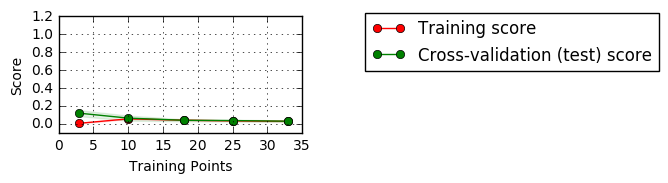

In [15]:
# try fitting a 2nd order polynomial, first with low noise sampling

calculateAndPlotLearningCurves(f, noise=0.1, npoints=50, degree=2)

In [16]:
# so you get a very low error, < 0.1

# what about with higher noise levels?

scoring mean_squared_error
degree 2
noise 0.5
npoints 50


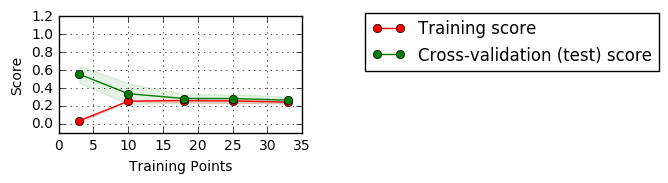

In [17]:
calculateAndPlotLearningCurves(f, noise=0.5, npoints=50, degree=2)

In [18]:
# so the curves converge at a higher error, ~0.25

# what about different degree polynomials?

### polynomial degree 1

scoring mean_squared_error
degree 1
noise 0.5
npoints 50


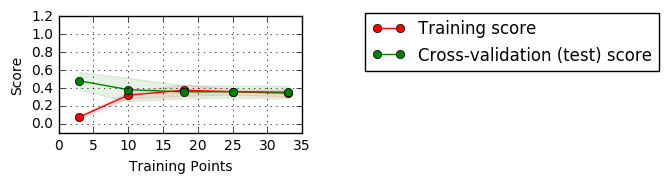

In [19]:
calculateAndPlotLearningCurves(f, noise=0.5, npoints=50, degree=1)

In [20]:
# the curves converge at a higher error ~0.4, indicating higher bias - 
# the model is not complex enough to model the data, so makes more errors.

### polynomial degree 4

scoring mean_squared_error
degree 4
noise 0.5
npoints 50


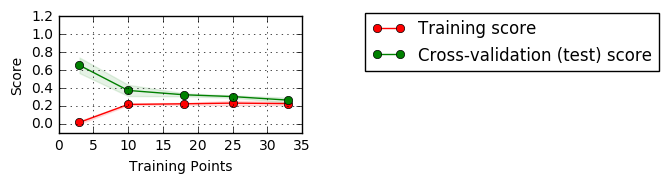

In [21]:
# what happens with degree=4?

calculateAndPlotLearningCurves(f, noise=0.5, npoints=50, degree=4)

In [22]:
# the curves take longer to converge, at about the same error of ~0.25.

# this indicates that you're getting more towards a regime of 
# high variance, which is indicated by the larger gap - 
# ie the model is starting to get more complex and starting to overfit to the training data.

In [23]:
# q. what does it mean when the errors converge quickly to a low error, as with degree=2?
# that you're in a regime with low bias and low variance, which is good.

# q. why would the training score and test score be the same as you add more training points?
# it means that the training distribution and test distribution are becoming more similar?

# q. why would the training and test scores be different with a higher degree polynomial?
# because the model fits to the specific training data, and the test data is different (overfitting).

# q. why is the training error so low (~0) for a low number of training points?
# because e.g. for degree=2, we can fit up to 3 points perfectly, hence training error = 0 for low ntrainpoints.
# as number of training points increases, it gets harder to fit them perfectly, so error increases.

# q. what is the relation between the value of `noise` and the converging mse score?
# as you increase noise, the error increases.
# but what's the precise functional relationship between them?

## Complexity Curves

In [24]:
# now want to see how the model works with increasing complexity.

# we'll basically be plotting the values of the learning curves at the end of the plots.
# so expect that for low complexity, the curves will be the same, with low error.
# and as you increase the complexity, the curves will have more error, and slowly diverge.

# as complexity gets too high though, the curves will diverge more - 
# the training error will head towards zero, while the test error will increase.
# this gap indicates a regime of high variance - the model is getting too complex and
# is overfitting to the training data (hence the lower training error). 
# but it performs worse with the test data, hence the test error will start increasing.

# in order to see the effect more easily, we'll reduce the number of sample points.

In [25]:
# define some fns

from sklearn.learning_curve import validation_curve # v0.16
#from sklearn.model_selection import validation_curve # v0.18

def plotComplexityCurves(degrees, trainScores, testScores):
    "plot training and test scores against complexity (polynomial degrees)"
    
    # validation_curve runs each case 3 times (the default for the cv parameter), 
    # so need to take average of them for plotting
    trainScoresMean = np.mean(trainScores,axis=1)
    testScoresMean = np.mean(testScores,axis=1)
    trainScoresStd = np.std(trainScores,axis=1)
    testScoresStd = np.std(testScores,axis=1)

    # make the plot
    plt.figure(figsize=figsize)

    plt.plot(degrees, trainScoresMean, 'o-', color="r", label="Training score")
    plt.plot(degrees, testScoresMean, 'o-', color="g", label="Cross-validation (test) score")

    plt.fill_between(degrees, trainScoresMean - trainScoresStd, trainScoresMean + trainScoresStd, 
                     alpha=0.1, color="r")
    plt.fill_between(degrees, testScoresMean - testScoresStd, testScoresMean + testScoresStd, 
                     alpha=0.1, color="g")
    
    if np.min(testScores) < 0: # r2 scores can be negative
        plt.ylim(-1,1)
    else:
        plt.ylim(0,1)
    plt.ylabel("Score")
    plt.xlabel("Polynomial Degree")
    plt.legend(bbox_to_anchor=(2.5, 1.1))
    plt.grid()
    plt.show()

In [26]:
def calculateAndPlotComplexityCurves(f, noise=0.0, npoints=6, maxDegree=8, scoring='mean_squared_error'):
    "calculate complexity curves by sampling from the given function and fitting polynomials to the sample data"
    
    # sample some data
    X, y = getSample(f, noise=noise, npoints=npoints)

    # create a polynomial model
    # note: a Pipeline lets you chain multiple estimators.
    # make_pipeline is a convenience function for Pipeline - 
    # see http://scikit-learn.org/stable/modules/pipeline.html#pipeline
    poly = make_pipeline(PolynomialFeatures(), Ridge())

    # create a validation curve
    # see http://scikit-learn.org/0.17/modules/generated/sklearn.learning_curve.validation_curve.html
    # note: to set parameter values on a pipeline, need to prefix the name with the step name and __.
    # see http://scikit-learn.org/stable/modules/pipeline.html#pipeline
    degrees = range(maxDegree+1)
    trainScores, testScores = validation_curve(poly, X, y, "polynomialfeatures__degree", degrees, scoring=scoring)
    if scoring=='mean_squared_error':
        trainScores = -trainScores
        testScores = -testScores
    print 'scoring',scoring
    
    # plot them
    plotComplexityCurves(degrees, trainScores, testScores)

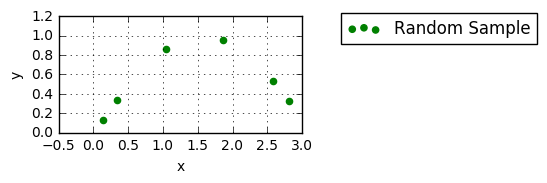

In [27]:
# first let's look at the type of sample we'll be fitting against

X, y = getSample(f, noise=0, npoints=6) # no noise!
plotSample(X,y)

In [28]:
# so we just have a small number of points to fit against -
# as the degree of the polynomial grows, we'll start running into overfitting problems.

scoring mean_squared_error


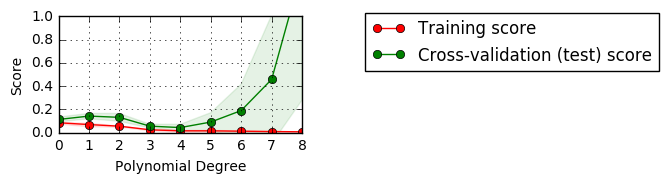

In [29]:
# plot a complexity curve, fitting against a similar sample

calculateAndPlotComplexityCurves(f, noise=0, npoints=6, maxDegree=8)

In [30]:
# note the characteristic U-shape of the test score - 

# on the left you have a regime of *underfitting*, or *high bias* - 
# the model doesn't have enough complexity to model the data very well.

# on the right you have *overfitting*, or *high variance* - 
# the model is too complex and fits too well to the training data,
# making it fit less well against the test data.
# note the high variance of the test scores also. 

# in the middle you have a happy medium with low test error at around 4 degrees.

scoring mean_squared_error


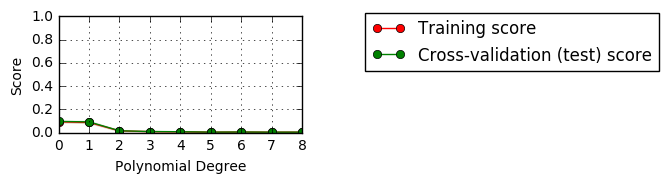

In [31]:
# one thing to note is that you might not always see the U-shape, 
# e.g. if the number of points is large, the U would be off the chart to the right -

calculateAndPlotComplexityCurves(f, noise=0.0, npoints=50, maxDegree=8)

## Conclusion

When a model is not complex enough to model the data, it's said to be **underfitting**, and is in a regime of **high bias**.

When a model is too complex, it's said to be **overfitting**, and is in a regime of **high variance**.

There should be a happy medium somewhere in between the two.

You can use a **learning curve** to diagnose these problems - if the training and testing errors converge towards a relatively high value, the model is probably **underfitting**. If there is a gap between them, and the training error is very low, the model is probably **overfitting**. 

When a model is **underfitting**, you should increase the model complexity - e.g. by adding more features. Adding more data is not likely to solve the problem.

When a model is **overfitting**, you should decrease the model complexity - e.g. by removing more features. Adding more data might also help. 

You can also use a **complexity curve** to identify a good amount of complexity for the model - there is a characteristic U-shape with the lowest area in between the underfitting and overfitting areas. 